In [1]:
from data_access import events_dataframe, update_data_file, DATA_FILE
from plots import cumulative_history_plot, add_interpoop_stats, sleep_time_plot

In [2]:
%load_ext autoreload


In [3]:
%autoreload 2

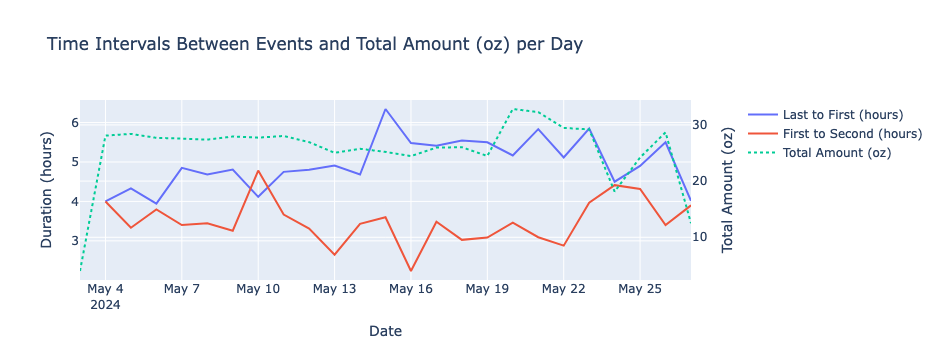

In [9]:
tz='US/Pacific'
df = events_dataframe()


sleep_time_plot(df,tz,oz_per_15_minutes_boobs=1.0)

In [40]:
intervals_df.iloc[0].last_to_first.total_seconds()/3600

4.0

In [2]:
import pandas as pd
import plotly.graph_objects as go

In [ ]:
!pwd

In [3]:
pd.Timestamp('2024-03-05 20:34', tz='US/Pacific').isoformat()

'2024-03-05T20:34:00-08:00'